In [ ]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches': 'tight'}
import cv2 as cv
import numpy as np
import scipy as sp
import scipy.stats
import math as m
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 96
mpl.rcParams['figure.dpi'] = 96
import matplotlib.pyplot as plt
from omrtemplate import get_template_rois
from pyzbar.pyzbar import decode


In [ ]:
SHOW_PROCESSING_STEPS = True
FIGSIZE=(15.5, 23)
# FIGSIZE=(5, 8)
CONTOUR_EPS = 0.02
COMPACTNESS_EPS = 0.1
AREA_EPS = 0.7
CLOSENESS_EPS = 1.5
CLAHE_CLIPLIMIT = 2.0
BLUR_KSIZE = 3
THRESH_BLOCK_SIZE = 33

In [ ]:
TEMPLATE_PATH = './response-sheet.svg'
SCAN_PATH = 'samples/omr_scan_012.jpg'

In [ ]:
# Load the image
import copy
import pickle
img_rgb = cv.imread(SCAN_PATH)

# Convert to gray tones
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
print(len(img_gray))
# print(decode(img_gray))
# Decode the QR-code
# qrcode = decode(img_gray)[0]
qrcode = None
# y = copy.copy(qrcode)
# with open('temp.pkl', 'wb') as output:
#     pickle.dump(y, output, pickle.HIGHEST_PROTOCOL)
with open('temp.pkl', 'rb') as input:
    qrcode = pickle.load(input)
#     print(qrcode)
# print(qrcode, y)
qrdata = qrcode.data.decode('utf-8').split()
department_id = qrdata[0]
course_id = qrdata[1]
exam_date = qrdata[2]
variants_count = int(qrdata[3])
questions_count = int(qrdata[4])
#print(variants_count)
#print(qrdata)

In [ ]:
mx = 0
my = 0
for p in qrcode.polygon:
    mx = mx + p.x
    my = my + p.y
    
mx = mx / 4
my = my / 4

height = img_gray.shape[0]
width = img_gray.shape[1]
img_corners = {(0, 0): 1, (width, 0): 0, (0, height): 2, (width, height): 3}
min_dist = m.sqrt(height**2 + width**2)
rotation_count = 0
for k in img_corners:
    dist = m.sqrt((mx-k[0])**2 + (my-k[1])**2)
    if min_dist > dist:
        min_dist = dist
        rotation_count = img_corners[k]

# Rotate the image such that the page is correctly oriented
for c in range(rotation_count):
    img_gray = cv.transpose(img_gray)
    img_gray = cv.flip(img_gray, flipCode=1)

# qrcode = decode(img_gray)[0]
qr_vertices = np.zeros((4, 1, 2), dtype=np.int32)
for idx in range(4):
    p = qrcode.polygon[idx]
    qr_vertices[idx][0][0] = p.x
    qr_vertices[idx][0][1] = p.y

plt.figure(figsize=FIGSIZE)
plt.axis("off")
plt.imshow(img_gray, cmap = plt.cm.gray);

In [ ]:
from lxml import etree
import re
import math as m
import numpy as np
def get_transform_matrix(transform_string):
    transform_regex = re.compile('(translate|rotate|scale|skewX|skewY|matrix)\(([^()]*)\)')
    transform_matrix = np.identity(3)
    for xformid, args in transform_regex.findall(transform_string):
        args = [float(a) for a in re.split(r'[^0-9eE+.-]+', args)]
        tm = np.identity(3)
        if xformid == 'translate':
            for idx in range(len(args)):
                tm[idx, 2] = args[idx]
        elif xformid == 'scale':
            if len(args) == 1:
                args = args * 2
            for idx in range(len(args)):
                tm[idx, idx] = args[idx]
        elif xformid == 'matrix':
            for idx in range(len(args)):
                tm[idx%2, idx//2] = args[idx]
        elif xformid == 'skewX':
            tm[0, 1] = m.tan(m.radians(args[0]))
        elif xformid == 'skewY':
            tm[1, 0] = m.tan(m.radians(args[0]))
        elif xformid == 'rotate':
            tm[0, 0] =  m.cos(m.radians(args[0]))
            tm[0, 1] = -m.sin(m.radians(args[0]))
            tm[1, 0] =  m.sin(m.radians(args[0]))
            tm[1, 1] =  m.cos(m.radians(args[0]))
            if len(args) > 1:
                pretm = np.identity(3)
                postm = np.identity(3)
                pretm[0, 2] = args[1]
                pretm[1, 2] = args[2]
                postm[0, 2] = -args[1]
                postm[1, 2] = -args[2]
                tm = pretm @ tm @ postm
        
        transform_matrix = transform_matrix @ tm
    return transform_matrix
def get_template_rois(filename):
    tree = etree.parse(open(filename, "r", encoding = 'utf-8'))
    root = tree.getroot()
    
    page_width = root.attrib['width']
    page_height = root.attrib['height']
    # drop units
    units = re.compile(r'[a-zA-Z\s]+')
    try:
        page_width = float(page_width)
    except:
        page_width = float(re.split(units, page_width)[0])
    try:
        page_height = float(page_height)
    except:
        page_height = float(re.split(units, page_height)[0])
    
    qr_root = tree.xpath('//svg:g[starts-with(@inkscape:label, "QR")]',
                           namespaces={'inkscape': 'http://www.inkscape.org/namespaces/inkscape',
                                       'svg': 'http://www.w3.org/2000/svg'})[0]
    qr_width = float(qr_root[0].attrib['width']) - 8*float(qr_root[1].attrib['width'])
    print(float(qr_root[0].attrib['width']), 8*float(qr_root[1].attrib['width']))
    print((qr_root[0].attrib['height']), 8*float(qr_root[1].attrib['height']))
    qr_height = float(qr_root[0].attrib['height']) - 8*float(qr_root[1].attrib['height'])
    ctm = np.identity(3)
    ctm_chain = [qr_root] + list(qr_root.iterancestors())
    ctm_chain.reverse()
    for el in ctm_chain:
        if 'transform' in el.attrib:
            ctm = ctm @ get_transform_matrix(el.attrib['transform'])
    initial_qr_orig = np.array([0, 0, 1.0], ndmin=2).T
    initial_qr_width = np.array([qr_width, 0, 1.0], ndmin=2).T
    initial_qr_height = np.array([0, qr_height, 1.0], ndmin=2).T
    mapped_qr_orig = ctm @ initial_qr_orig
    mapped_qr_width = ctm @ initial_qr_width
    mapped_qr_height = ctm @ initial_qr_height
    qr_x = mapped_qr_orig[0][0]
    qr_y = mapped_qr_orig[1][0]
    qr_width = np.linalg.norm(mapped_qr_orig - mapped_qr_width)
    qr_height = np.linalg.norm(mapped_qr_orig - mapped_qr_height)
    rois_root = tree.findall('{*}g[@inkscape:groupmode="layer"][@inkscape:label="ROIs"]',
                             namespaces={'inkscape': 'http://www.inkscape.org/namespaces/inkscape',
                                        'svg': 'http://www.w3.org/2000/svg'})[0]
    ctm = np.identity(3)
    ctm_chain = [rois_root] + list(rois_root.iterancestors())
    ctm_chain.reverse()
    for el in ctm_chain:
        if 'transform' in el.attrib:
            ctm = ctm @ get_transform_matrix(el.attrib['transform'])
    bounding_rect = None
    answer_bubbles = []
    for el in rois_root:
        tag = etree.QName(el).localname
        if tag == 'rect' or tag == 'circle':
            tm = np.copy(ctm)
            if 'transform' in el.attrib:
                tm = tm @ get_transform_matrix(el.attrib['transform'])
            if tag == 'rect':
                rect_attribs = {k:float(el.attrib[k]) for k in ['x', 'y', 'width', 'height']}
                if 'style' in el.attrib:
                    rect_style = dict(item.split(":") for item in el.attrib['style'].split(";"))
                    if 'stroke-width' in rect_style:
                        rect_attribs['stroke-width'] = float(rect_style['stroke-width'])
                    else:
                        rect_attribs['stroke-width'] = 0.0
                initial_ul = np.array([rect_attribs['x'], rect_attribs['y'], 1.0], ndmin=2).T
                initial_width = initial_ul + np.array([rect_attribs['width'], 0, 0], ndmin=2).T
                initial_height = initial_ul + np.array([0, rect_attribs['height'], 0], ndmin=2).T
                initial_stroke = initial_ul + np.array([rect_attribs['stroke-width'], 0, 0], ndmin=2).T
                mapped_ul = tm @ initial_ul
                mapped_width = tm @ initial_width
                mapped_height = tm @ initial_height
                mapped_stroke = tm @ initial_stroke
                rect_attribs['x'] = mapped_ul[0][0]
                rect_attribs['y'] = mapped_ul[1][0]
                rect_attribs['width'] = np.linalg.norm(mapped_width - mapped_ul)
                rect_attribs['height'] = np.linalg.norm(mapped_height - mapped_ul)
                rect_attribs['stroke-width'] = np.linalg.norm(mapped_stroke - mapped_ul)
            elif tag == 'circle':
                circle_attribs = {k:float(el.attrib[k]) for k in ['cx', 'cy', 'r']}
                initial_c = np.array([circle_attribs['cx'], circle_attribs['cy'], 1.0], ndmin=2).T
                initial_r = initial_c + np.array([circle_attribs['r'], 0, 0], ndmin=2).T
                mapped_c = tm @ initial_c
                mapped_r = tm @ initial_r
                circle_attribs['cx'] = mapped_c[0][0]
                circle_attribs['cy'] = mapped_c[1][0]
                circle_attribs['r'] = np.linalg.norm(mapped_r - mapped_c)

                circle_attribs['id'] = el.attrib['id']
                if 'style' in el.attrib:
                    circle_style = dict(item.split(":") for item in el.attrib['style'].split(";"))
                    if 'stroke-width' in circle_style:
                        circle_attribs['stroke-width'] = float(circle_style['stroke-width'])
                    else:
                        circle_attribs['stroke-width'] = 0.0
                answer_bubbles.append(circle_attribs)
    return ({'height': page_height, 'width': page_width}, 
           {'x': qr_x, 'y': qr_y, 'height': qr_height, 'width': qr_width},
            rect_attribs,
            answer_bubbles)

In [ ]:
# get template informations from the svg file
page_dims, qr_dims, bounding_rect, answer_bubbles = get_template_rois(TEMPLATE_PATH)
print(page_dims, qr_dims)
# print(bounding_rect)
# print(answer_bubbles)
# crop the page to edges, in relation to qr shape
qr_deltas = qr_vertices - np.roll(qr_vertices, 1, axis=0)
qr_lengths = [int(np.linalg.norm(d)) for d in qr_deltas]
new_qr_width = max(qr_lengths)
new_qr_height = int(qr_dims['height'] * new_qr_width / qr_dims['width'])
qr_x = qr_vertices[0][0][0]
qr_y = qr_vertices[0][0][1]
new_qr_vertices = np.array([
        [qr_x, qr_y],
        [qr_x, qr_y + new_qr_height - 1],
        [qr_x + new_qr_width - 1, qr_y + new_qr_height - 1],
        [qr_x + new_qr_width - 1, qr_y]], dtype = "float32")
resh_qr_vertices = np.float32(np.reshape(qr_vertices, (4, 2)))

In [ ]:
# compute the perspective transform matrix and then apply it
M = cv.getPerspectiveTransform(resh_qr_vertices, new_qr_vertices)
img_qr_box = cv.warpPerspective(img_gray,
                                M,
                                (int(img_gray.shape[1]*1.2), int(img_gray.shape[0]*1.2)))
marg_lx = bounding_rect['x'] / 3
marg_ly = bounding_rect['y'] / 3
marg_rx = (page_dims['width'] - (bounding_rect['x'] + bounding_rect['width'])) / 3
marg_ry = (page_dims['height'] - (bounding_rect['y'] + bounding_rect['height'])) / 3
print(qr_dims)
new_page_xul = int(new_qr_vertices[0][0] - (qr_dims['x'] + marg_lx) * new_qr_width / qr_dims['width'])
if new_page_xul < 0:
    new_page_xul = 0
new_page_yul = int(new_qr_vertices[0][1] - (qr_dims['y'] + marg_ly)* new_qr_height / qr_dims['height'])
if new_page_yul < 0:
    new_page_yul = 0
new_page_xlr = int(new_qr_vertices[0][0] +
                   (page_dims['width'] - qr_dims['x'] - marg_rx) * new_qr_width / qr_dims['width'])
if new_page_xlr > img_qr_box.shape[1]:
    new_page_xlr = img_qr_box.shape[1]
new_page_ylr = int(new_qr_vertices[0][1] +
                   (page_dims['height'] - qr_dims['y'] - marg_ry) * new_qr_height / qr_dims['height'])
if new_page_ylr > img_qr_box.shape[0]:
    new_page_ylr = img_qr_box.shape[0]

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_qr_box, cmap = plt.cm.gray);
# crop the image
img_qr_box = img_qr_box[new_page_yul:new_page_ylr, new_page_xul:new_page_xlr]

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_qr_box, cmap = plt.cm.gray);

In [ ]:
# create a CLAHE object
clahe = cv.createCLAHE(clipLimit=CLAHE_CLIPLIMIT)
# apply CLAHE for better contrast
img_clahe = clahe.apply(img_qr_box)
# img_clahe = clahe

# apply blur
img_blur = cv.GaussianBlur(img_clahe, (15, 15), 0)

# apply adaptive thresholding
img_th = cv.adaptiveThreshold(img_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                              cv.THRESH_BINARY, THRESH_BLOCK_SIZE, THRESH_BLOCK_SIZE//2)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_th, cmap = plt.cm.gray);

In [ ]:
# apply dialation
kernel = np.ones((5,5), np.uint8)
img_dialation = cv.dilate(img_th, kernel, iterations = 1)

In [ ]:
# apply canny edge detection
    
img_canny = cv.Canny(img_dialation, 75, 200)
# find contours in the edged image
_, contours, _ = cv.findContours(img_canny, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

# select the max area contour
contour = max(contours, key = cv.contourArea)
perimeter = cv.arcLength(contour, True)
approx_contour = cv.approxPolyDP(contour, CONTOUR_EPS * perimeter, True)
vertices = cv.convexHull(approx_contour, clockwise=True)
img_result = cv.drawContours(cv.cvtColor(img_qr_box, cv.COLOR_GRAY2BGR), [vertices], 0, (0,255,0), 3)
if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_result);

In [ ]:
print(vertices)
# x,y,w,h = cv.boundingRect(approx_contour)
# print(x,y,w,h)
# c = vertices
# print(c) 
# # determine the most extreme points along the contour
# extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot = tuple(c[c[:, :, 1].argmax()][0])
c = np.ndarray(shape=(4,1,2), dtype=int)
d = np.ndarray(shape=(4,1), dtype=np.ndarray)

c[0][0][0], c[0][0][1] = 203, 280
c[1][0][0], c[1][0][1] = 261, 3213
c[2][0][0], c[2][0][1] = 2132, 3040
c[3][0][0], c[3][0][1] = 2161, 266
print(c)
# vertices = c

In [ ]:
box_frac = bounding_rect['stroke-width'] / bounding_rect['width']
norms = [np.linalg.norm(d) for d in vertices]
vertices = np.roll(vertices, -np.argmin(norms), axis=0)
print(vertices)
# vertices = vertices[0:2]+vertices[4:]
deltas = vertices - np.roll(vertices, 1, axis=0)
lengths = [int(np.linalg.norm(d)) for d in deltas]
dim = max(lengths)
new_height = dim
new_width = dim * int(bounding_rect['width'] - bounding_rect['stroke-width']) // \
            int(bounding_rect['height'] - bounding_rect['stroke-width'])
new_vertices = np.array([
        [0, 0],
        [0, new_height - 1],
        [new_width - 1, new_height - 1],
        [new_width - 1, 0]], dtype = "float32")
vertices = np.float32(np.reshape(vertices, (4, 2)))
# compute the perspective transform matrix and then apply it
M = cv.getPerspectiveTransform(vertices, new_vertices)
img_box = cv.warpPerspective(img_qr_box, M, (new_width, new_height))
crop_width = int(np.round(img_box.shape[0] * box_frac))

translate_tm = np.identity(3)
translate_tm[0, 2] = -bounding_rect['x']
translate_tm[1, 2] = -bounding_rect['y']
scale_tm = np.identity(3)
scale_factor = img_box.shape[1] / (bounding_rect['width'] + bounding_rect['stroke-width'])
scale_tm[0, 0] = scale_factor
scale_tm[1, 1] = scale_factor
map_tm = scale_tm @ translate_tm


In [ ]:
# map bubbles template coordinates to image coordinates
initial_r = np.array([answer_bubbles[0]['r'], 0, 1.0], ndmin=2).T
mapped_r = np.ceil(scale_tm @ initial_r)
circle_r = mapped_r[0][0]
circle_area = m.pi * circle_r**2
circle_peri = 2 * m.pi * circle_r
# print(answer_bubbles)
for idx in range(len(answer_bubbles)):
    initial_coords = np.array([answer_bubbles[idx]['cx'], answer_bubbles[idx]['cy'], 1.0], ndmin=2).T
    mapped_coords = map_tm  @ initial_coords
    answer_bubbles[idx]['cx'] = int(mapped_coords[0,0])
    answer_bubbles[idx]['cy'] = int(mapped_coords[1,0])
    answer_bubbles[idx]['r'] = circle_r
    print(answer_bubbles[idx])
# crop the margins
img_box = img_box[crop_width:img_box.shape[0]-crop_width, crop_width:img_box.shape[1]-crop_width]

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box, cmap = plt.cm.gray);

In [ ]:
# create a CLAHE object
clahe_box = cv.createCLAHE(clipLimit=CLAHE_CLIPLIMIT)
# apply CLAHE for better contrast
img_box_clahe = clahe.apply(img_box)

# apply blur
img_box_blur = cv.GaussianBlur(img_box_clahe, (BLUR_KSIZE, BLUR_KSIZE), 0)

# apply adaptive thresholding
img_box_th = cv.adaptiveThreshold(img_box_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                  cv.THRESH_BINARY, THRESH_BLOCK_SIZE, THRESH_BLOCK_SIZE//2)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_th, cmap = plt.cm.gray);

In [ ]:
# apply canny edge detection
img_box_canny = cv.Canny(img_box_th, 75, 200)

# find contours in the boxed image
_, box_contours, _ = cv.findContours(img_box_canny, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)


img_box_result = cv.drawContours(cv.cvtColor(img_box, cv.COLOR_GRAY2BGR), box_contours, -1, (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

In [ ]:
by_compactness_contours = []
for c in box_contours:
    moments = cv.moments(c)
    if moments['mu20']+moments['mu02'] != 0:
        compactness = moments['m00']**2/(2*m.pi*(moments['mu20']+moments['mu02']))
        if abs(compactness - 1) < COMPACTNESS_EPS:
            by_compactness_contours.append(c)

img_box_result = cv.drawContours(cv.cvtColor(img_box, cv.COLOR_GRAY2BGR),
                                 by_compactness_contours, -1, (0,255,255), 1)


if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

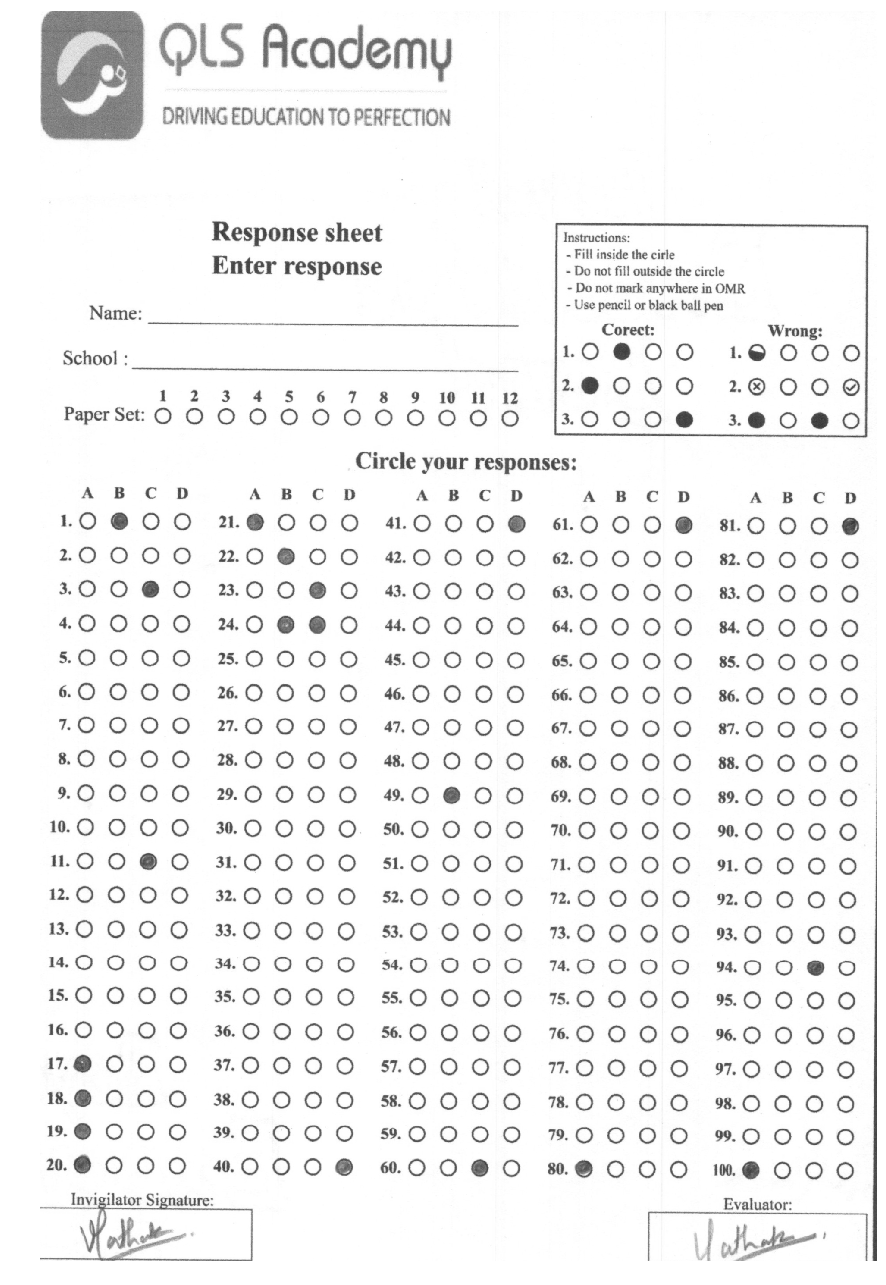

In [123]:
by_area_contours = [c for c in by_compactness_contours \
                    if abs((circle_area - cv.contourArea(c)) / circle_area) <= AREA_EPS]
img_box_result = cv.drawContours(cv.cvtColor(img_box, cv.COLOR_GRAY2BGR),
                                 by_area_contours, -1, (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);

In [124]:
# filter contours by selecting only the contours in expected locations
# (i.e. by closeness to the expected locations)
# if several contours are close to the expected locations,
# only select the largest ones

for c in by_area_contours:
    moments = cv.moments(c)
    mx = moments['m10'] / moments['m00']
    my = moments['m01'] / moments['m00']
    min_dist = circle_r * (1 + CLOSENESS_EPS)
    bubble_pair = 0
    for bubble_idx in range(len(answer_bubbles)):
        bubble = answer_bubbles[bubble_idx]
        cx = bubble['cx']
        cy = bubble['cy']
        if min_dist > m.sqrt((cx - mx)**2 + (cy - my)**2):
            min_dist = m.sqrt((cx - mx)**2 + (cy - my)**2)
            bubble_pair = bubble_idx
    if abs(min_dist - circle_r) / circle_r < CLOSENESS_EPS:
        if 'contours' in answer_bubbles[bubble_pair]:
            answer_bubbles[bubble_pair]['contours'].append(c)
        else:
            answer_bubbles[bubble_pair]['contours'] = [c]

for bubble in answer_bubbles:
    if 'contours' in bubble:
        print(bubble)
        max_contour = max(bubble['contours'], key = cv.contourArea)
        moments = cv.moments(max_contour)
        mx = int(moments['m10'] / moments['m00'])
        my = int(moments['m01'] / moments['m00'])
        bubble['mx'] = mx
        bubble['my'] = my
        bubble['optimal_contour'] = max_contour

img_box_result = cv.cvtColor(img_box, cv.COLOR_GRAY2BGR)

{'optimal_contour': array([[[282, 921]],

       [[281, 922]],

       [[280, 922]],

       [[279, 922]],

       [[278, 923]],

       [[277, 923]],

       [[276, 924]],

       [[275, 924]],

       [[274, 925]],

       [[273, 925]],

       [[272, 926]],

       [[271, 926]],

       [[270, 927]],

       [[269, 928]],

       [[269, 929]],

       [[268, 930]],

       [[267, 931]],

       [[266, 932]],

       [[266, 933]],

       [[265, 934]],

       [[265, 935]],

       [[265, 936]],

       [[265, 937]],

       [[264, 938]],

       [[264, 939]],

       [[264, 940]],

       [[264, 941]],

       [[264, 942]],

       [[264, 943]],

       [[265, 944]],

       [[265, 945]],

       [[265, 946]],

       [[265, 947]],

       [[266, 948]],

       [[266, 949]],

       [[267, 950]],

       [[268, 951]],

       [[268, 952]],

       [[269, 953]],

       [[269, 954]],

       [[270, 955]],

       [[271, 956]],

       [[272, 956]],

       [[273, 957]],

       [[274

{'optimal_contour': array([[[ 255, 1322]],

       [[ 254, 1323]],

       [[ 253, 1323]],

       [[ 252, 1323]],

       [[ 251, 1323]],

       [[ 250, 1324]],

       [[ 249, 1324]],

       [[ 248, 1324]],

       [[ 247, 1325]],

       [[ 246, 1325]],

       [[ 245, 1326]],

       [[ 244, 1326]],

       [[ 243, 1327]],

       [[ 242, 1328]],

       [[ 241, 1329]],

       [[ 240, 1330]],

       [[ 240, 1331]],

       [[ 239, 1332]],

       [[ 239, 1333]],

       [[ 238, 1334]],

       [[ 238, 1335]],

       [[ 237, 1336]],

       [[ 237, 1337]],

       [[ 236, 1338]],

       [[ 236, 1339]],

       [[ 236, 1340]],

       [[ 236, 1341]],

       [[ 235, 1342]],

       [[ 235, 1343]],

       [[ 235, 1344]],

       [[ 235, 1345]],

       [[ 236, 1346]],

       [[ 236, 1347]],

       [[ 237, 1348]],

       [[ 237, 1349]],

       [[ 237, 1350]],

       [[ 238, 1351]],

       [[ 238, 1352]],

       [[ 239, 1353]],

       [[ 240, 1354]],

       [[ 240, 1355]

{'optimal_contour': array([[[ 101, 1873]],

       [[ 100, 1874]],

       [[  99, 1874]],

       [[  98, 1874]],

       [[  97, 1875]],

       [[  96, 1875]],

       [[  95, 1875]],

       [[  94, 1876]],

       [[  93, 1876]],

       [[  92, 1877]],

       [[  91, 1878]],

       [[  90, 1879]],

       [[  90, 1880]],

       [[  89, 1881]],

       [[  88, 1882]],

       [[  87, 1883]],

       [[  87, 1884]],

       [[  86, 1885]],

       [[  86, 1886]],

       [[  85, 1887]],

       [[  85, 1888]],

       [[  85, 1889]],

       [[  85, 1890]],

       [[  85, 1891]],

       [[  84, 1892]],

       [[  84, 1893]],

       [[  84, 1894]],

       [[  84, 1895]],

       [[  84, 1896]],

       [[  85, 1897]],

       [[  85, 1898]],

       [[  85, 1899]],

       [[  85, 1900]],

       [[  86, 1901]],

       [[  86, 1902]],

       [[  87, 1903]],

       [[  87, 1904]],

       [[  88, 1905]],

       [[  88, 1906]],

       [[  89, 1907]],

       [[  90, 1908]

       [[ 248, 2264]]], dtype=int32)], 'my': 2285, 'stroke-width': 0.30000001, 'cx': 2866, 'mx': 247, 'r': 197.0}
{'optimal_contour': array([[[ 321, 2264]],

       [[ 320, 2265]],

       [[ 319, 2265]],

       [[ 318, 2265]],

       [[ 317, 2266]],

       [[ 316, 2266]],

       [[ 315, 2266]],

       [[ 314, 2266]],

       [[ 313, 2267]],

       [[ 312, 2267]],

       [[ 311, 2268]],

       [[ 310, 2268]],

       [[ 309, 2269]],

       [[ 308, 2270]],

       [[ 307, 2271]],

       [[ 306, 2272]],

       [[ 305, 2273]],

       [[ 304, 2274]],

       [[ 304, 2275]],

       [[ 303, 2276]],

       [[ 302, 2277]],

       [[ 302, 2278]],

       [[ 301, 2279]],

       [[ 301, 2280]],

       [[ 301, 2281]],

       [[ 300, 2282]],

       [[ 300, 2283]],

       [[ 300, 2284]],

       [[ 300, 2285]],

       [[ 300, 2286]],

       [[ 300, 2287]],

       [[ 300, 2288]],

       [[ 300, 2289]],

       [[ 300, 2290]],

       [[ 301, 2291]],

       [[ 301, 2292]],

  

{'optimal_contour': array([[[ 639, 1168]],

       [[ 638, 1169]],

       [[ 637, 1169]],

       [[ 636, 1170]],

       [[ 635, 1170]],

       [[ 634, 1171]],

       [[ 633, 1171]],

       [[ 632, 1172]],

       [[ 631, 1172]],

       [[ 630, 1173]],

       [[ 629, 1174]],

       [[ 628, 1175]],

       [[ 628, 1176]],

       [[ 627, 1177]],

       [[ 627, 1178]],

       [[ 626, 1179]],

       [[ 626, 1180]],

       [[ 625, 1181]],

       [[ 625, 1182]],

       [[ 625, 1183]],

       [[ 625, 1184]],

       [[ 624, 1185]],

       [[ 624, 1186]],

       [[ 624, 1187]],

       [[ 624, 1188]],

       [[ 624, 1189]],

       [[ 624, 1190]],

       [[ 624, 1191]],

       [[ 624, 1192]],

       [[ 625, 1193]],

       [[ 625, 1194]],

       [[ 625, 1195]],

       [[ 626, 1196]],

       [[ 626, 1197]],

       [[ 627, 1198]],

       [[ 627, 1199]],

       [[ 627, 1200]],

       [[ 628, 1201]],

       [[ 628, 1202]],

       [[ 629, 1202]],

       [[ 630, 1203]

{'optimal_contour': array([[[ 565, 1718]],

       [[ 564, 1719]],

       [[ 563, 1719]],

       [[ 562, 1719]],

       [[ 561, 1720]],

       [[ 560, 1720]],

       [[ 559, 1720]],

       [[ 558, 1721]],

       [[ 557, 1721]],

       [[ 556, 1722]],

       [[ 555, 1723]],

       [[ 554, 1723]],

       [[ 553, 1724]],

       [[ 552, 1725]],

       [[ 551, 1726]],

       [[ 551, 1727]],

       [[ 550, 1728]],

       [[ 550, 1729]],

       [[ 549, 1730]],

       [[ 549, 1731]],

       [[ 548, 1732]],

       [[ 548, 1733]],

       [[ 547, 1734]],

       [[ 547, 1735]],

       [[ 547, 1736]],

       [[ 546, 1737]],

       [[ 546, 1738]],

       [[ 546, 1739]],

       [[ 546, 1740]],

       [[ 546, 1741]],

       [[ 546, 1742]],

       [[ 547, 1743]],

       [[ 547, 1744]],

       [[ 548, 1745]],

       [[ 548, 1746]],

       [[ 549, 1747]],

       [[ 549, 1748]],

       [[ 550, 1749]],

       [[ 550, 1750]],

       [[ 551, 1751]],

       [[ 551, 1752]

{'optimal_contour': array([[[ 559, 2194]],

       [[ 558, 2195]],

       [[ 557, 2195]],

       [[ 556, 2195]],

       [[ 555, 2196]],

       [[ 554, 2196]],

       [[ 553, 2196]],

       [[ 552, 2197]],

       [[ 551, 2197]],

       [[ 550, 2198]],

       [[ 549, 2198]],

       [[ 548, 2199]],

       [[ 547, 2200]],

       [[ 546, 2200]],

       [[ 545, 2201]],

       [[ 544, 2202]],

       [[ 544, 2203]],

       [[ 543, 2204]],

       [[ 543, 2205]],

       [[ 542, 2206]],

       [[ 542, 2207]],

       [[ 542, 2208]],

       [[ 542, 2209]],

       [[ 542, 2210]],

       [[ 542, 2211]],

       [[ 542, 2212]],

       [[ 542, 2213]],

       [[ 542, 2214]],

       [[ 542, 2215]],

       [[ 543, 2216]],

       [[ 543, 2217]],

       [[ 544, 2218]],

       [[ 544, 2219]],

       [[ 545, 2220]],

       [[ 545, 2221]],

       [[ 546, 2222]],

       [[ 547, 2223]],

       [[ 547, 2224]],

       [[ 548, 2225]],

       [[ 549, 2226]],

       [[ 550, 2226]

{'optimal_contour': array([[[ 481, 2660]],

       [[ 480, 2661]],

       [[ 479, 2661]],

       [[ 478, 2662]],

       [[ 477, 2663]],

       [[ 476, 2664]],

       [[ 475, 2664]],

       [[ 474, 2665]],

       [[ 473, 2665]],

       [[ 472, 2666]],

       [[ 471, 2667]],

       [[ 470, 2668]],

       [[ 470, 2669]],

       [[ 469, 2670]],

       [[ 469, 2671]],

       [[ 468, 2672]],

       [[ 467, 2673]],

       [[ 467, 2674]],

       [[ 466, 2675]],

       [[ 466, 2676]],

       [[ 466, 2677]],

       [[ 466, 2678]],

       [[ 466, 2679]],

       [[ 466, 2680]],

       [[ 466, 2681]],

       [[ 466, 2682]],

       [[ 465, 2683]],

       [[ 466, 2684]],

       [[ 466, 2685]],

       [[ 466, 2686]],

       [[ 466, 2687]],

       [[ 467, 2688]],

       [[ 467, 2689]],

       [[ 468, 2690]],

       [[ 468, 2691]],

       [[ 469, 2692]],

       [[ 470, 2693]],

       [[ 470, 2694]],

       [[ 471, 2695]],

       [[ 472, 2696]],

       [[ 473, 2697]

{'optimal_contour': array([[[ 878, 1564]],

       [[ 877, 1565]],

       [[ 876, 1565]],

       [[ 875, 1566]],

       [[ 874, 1566]],

       [[ 873, 1566]],

       [[ 872, 1567]],

       [[ 871, 1568]],

       [[ 870, 1569]],

       [[ 869, 1570]],

       [[ 868, 1571]],

       [[ 867, 1572]],

       [[ 867, 1573]],

       [[ 866, 1574]],

       [[ 865, 1575]],

       [[ 864, 1576]],

       [[ 864, 1577]],

       [[ 863, 1578]],

       [[ 863, 1579]],

       [[ 863, 1580]],

       [[ 863, 1581]],

       [[ 862, 1582]],

       [[ 862, 1583]],

       [[ 862, 1584]],

       [[ 862, 1585]],

       [[ 862, 1586]],

       [[ 862, 1587]],

       [[ 862, 1588]],

       [[ 863, 1589]],

       [[ 863, 1590]],

       [[ 863, 1591]],

       [[ 863, 1592]],

       [[ 864, 1593]],

       [[ 864, 1594]],

       [[ 865, 1595]],

       [[ 865, 1596]],

       [[ 866, 1597]],

       [[ 866, 1598]],

       [[ 867, 1599]],

       [[ 868, 1600]],

       [[ 869, 1600]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'optimal_contour': array([[[1865, 2670]],

       [[1864, 2671]],

       [[1863, 2671]],

       [[1862, 2672]],

       [[1861, 2672]],

       [[1860, 2672]],

       [[1859, 2673]],

       [[1858, 2673]],

       [[1857, 2674]],

       [[1856, 2674]],

       [[1855, 2675]],

       [[1854, 2675]],

       [[1853, 2676]],

       [[1852, 2677]],

       [[1851, 2678]],

       [[1851, 2679]],

       [[1850, 2680]],

       [[1849, 2681]],

       [[1849, 2682]],

       [[1848, 2683]],

       [[1848, 2684]],

       [[1848, 2685]],

       [[1847, 2686]],

       [[1847, 2687]],

       [[1847, 2688]],

       [[1846, 2689]],

       [[1846, 2690]],

       [[1846, 2691]],

       [[1846, 2692]],

       [[1846, 2693]],

       [[1846, 2694]],

       [[1847, 2695]],

       [[1847, 2696]],

       [[1848, 2697]],

       [[1848, 2698]],

       [[1848, 2699]],

       [[1848, 2700]],

       [[1849, 2701]],

       [[1849, 2702]],

       [[1850, 2703]],

       [[1851, 2704

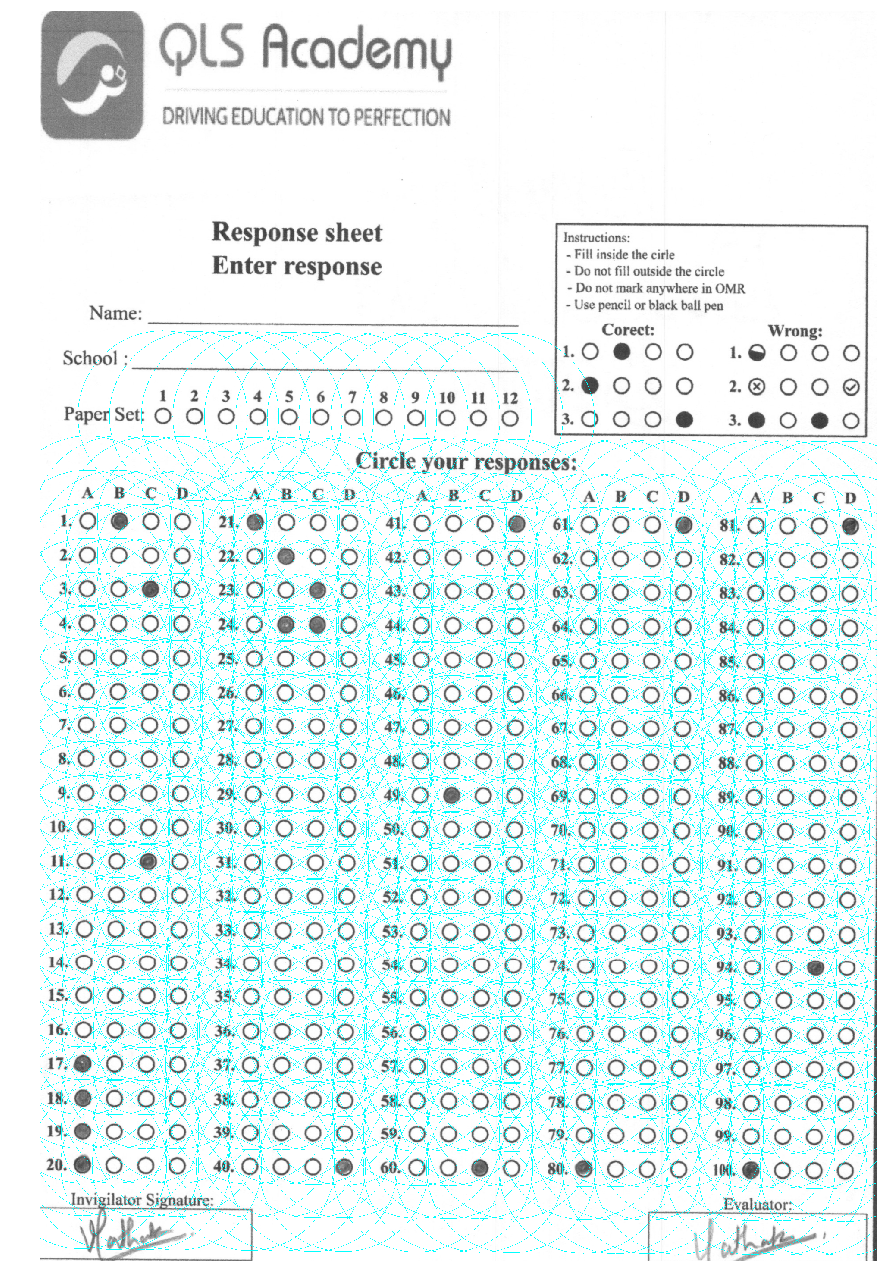

In [125]:
# draw bubbles
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        cv.circle(img_box_result,
              (bubble['mx'], bubble['my']), int(circle_r), (0,255,255), 1)

if SHOW_PROCESSING_STEPS:
    plt.figure(figsize=FIGSIZE)
    plt.axis("off")
    plt.imshow(img_box_result);


In [126]:
# classify bubbles into 'filled' and 'not filled'
mask = np.zeros((*img_box_th.shape,), np.uint8)
bubble_means = []
print(len(answer_bubbles))
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        mask[...] = 0
        cv.circle(mask, (bubble['mx'], bubble['my']), int(circle_r), 255, -1)
        bubble['mean'] = cv.mean(img_box_th, mask)[0]
        bubble_means.append(bubble['mean'])
filled_threshold = np.mean(bubble_means) * 0.9
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        bubble['is_filled'] = bubble['mean'] < filled_threshold

412


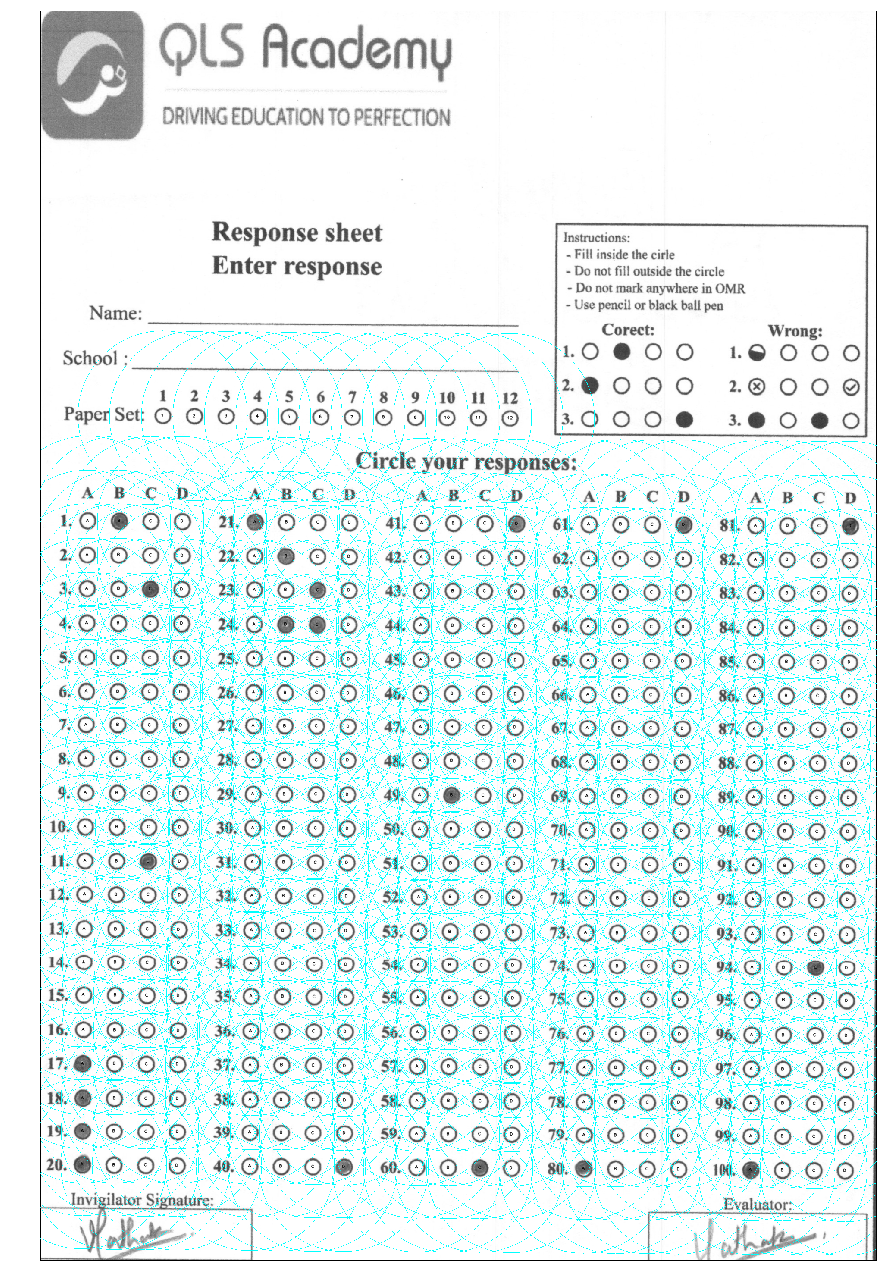

In [127]:
# draw bubbles according to the previous classification
font = cv.FONT_HERSHEY_PLAIN
#font = cv.FONT_HERSHEY_SIMPLEX
font_size = 0.7
bubble_color = (0, 255, 255)
#img_box_result = 255 * np.ones((*img_box_result.shape,), np.uint8)
img_box_result = cv.cvtColor(img_box, cv.COLOR_GRAY2BGR)
cv.rectangle(img_box_result, (0, 0), (img_box_result.shape[1], img_box_result.shape[0]), (0,0,0), 3)

for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        if bubble['is_filled']:
            cv.circle(img_box_result,
                  (bubble['mx'], bubble['my']), int(circle_r), (0,0,0), -1)
        cv.circle(img_box_result,
              (bubble['mx'], bubble['my']), int(circle_r), bubble_color, 1)
        id_parts = bubble['id'].split('-')
        if len(id_parts) > 1:
            text = id_parts[1]
        else:
            text = id_parts[0]
        text = text.upper()
        # get boundary of this text
        textsize = cv.getTextSize(text, font, font_size, 1)
        # get coords based on boundary
        textX = bubble['mx'] - textsize[0][0] // 2
        textY = bubble['my'] + textsize[0][1] // 2
        cv.putText(img_box_result, text,
                   (textX, textY),
                   font, font_size,
                   (255,255,255) if bubble['is_filled'] else (0,0,0), 1, cv.LINE_AA)


plt.figure(figsize=FIGSIZE)
plt.axis("off")
plt.imshow(img_box_result);

In [128]:
# find all answers

answers = {}
for bubble in answer_bubbles:
    if 'optimal_contour' in bubble:
        id, pos = bubble['id'].split('-')
        if id in answers:
            answers[id][pos] = bubble['is_filled']
        else:
            answers[id] = {pos: bubble['is_filled']}
print(answers)
valid_answers = {}
for key in answers:
    try:
        q = int(key)
        if (q <= questions_count  and
            list(answers[key].values()).count(True) == 1):
            valid_answers[key] = answers[key]
    except:
        pass
print(valid_answers)
# get variant number
# print(answers['v'])
variant = 0
if ('v' in answers and len(answers['v']) ==  variants_count and 
    list(answers['v'].values()).count(True) == 1):
    variant = int(list(answers['v'].keys())[list(answers['v'].values()).index(True)])

if variant > 0:
    print("Paper set: {:2d}".format(variant))
else:
    print("Submitted answers!")
for q in sorted(valid_answers, key = lambda x: int(x)):
    ans = list(valid_answers[q].keys())[list(valid_answers[q].values()).index(True)]
    print("{:3d} -> {:s}".format(int(q), ans.upper()))

{'49': {'c': False, 'b': False, 'd': False, 'a': False}, '40': {'c': False, 'b': False, 'd': False, 'a': False}, '68': {'c': False, 'b': False, 'd': False, 'a': False}, '79': {'c': False, 'b': False, 'd': False, 'a': False}, '82': {'c': False, 'b': False, 'd': False, 'a': False}, '90': {'c': False, 'b': False, 'd': False, 'a': False}, '9': {'c': False, 'b': False, 'd': False, 'a': False}, '44': {'c': False, 'b': False, 'd': False, 'a': False}, '41': {'c': False, 'b': False, 'd': False, 'a': False}, '74': {'c': False, 'b': False, 'd': False, 'a': False}, '53': {'c': False, 'b': False, 'd': False, 'a': False}, '32': {'c': False, 'b': False, 'd': False, 'a': False}, '33': {'c': False, 'b': False, 'd': False, 'a': False}, '12': {'c': False, 'b': False, 'd': False, 'a': False}, '7': {'c': False, 'b': False, 'd': False, 'a': False}, '88': {'c': False, 'b': False, 'd': False, 'a': False}, '64': {'c': False, 'b': False, 'd': False, 'a': False}, '87': {'c': False, 'b': False, 'd': False, 'a': F